<div align="center">

# Classification of Credit Card Transaction data
<h4>
  Wesley Dyk<br>
  <small style="font-weight: normal;">
    Senior Quantum Solutions Architect<br>
    Quantum Computing Inc.
  </small>
</h4>

<br>

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/qci-wdyk/eqc-models-tutorial/blob/main/tutorial06-classification-fraud.ipynb)

</div>


A `QBoostClassifier` object builds $n$ weak classifiers from one of Decision Tree, Gaussian Naive Bayes, Logistic Regression, or Gaussian Process classifiers. Logistic Regression is the default. The number of classifiers, $n$ is determined as 1,2 or 3-combinations of all features. These classifiers are used to build a Hamiltonian whose minima represents an optimal linear combination of the weak classifiers correctly classifying the most records of the training dataset.

The transaction data includes 43 columns including scalar values, flags and and identifier. We will use 30 scalar features for the independent data and the Class feature as the response. Logistic regression is the default weak classifier model and we will use it for this dataset. The process uses the scikit-learn MinMaxScaler and an assignment of -1 for the 0 label, so 1 is fraud and -1 is a legitimate transaction. The dataset can be retrieved from [https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud).

## Imports

In [1]:
import sys
import os
import warnings
warnings.filterwarnings("ignore")
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    recall_score,
    accuracy_score,
    roc_curve,
    auc
)
from imblearn.over_sampling import ADASYN

from eqc_models.ml.classifierqboost import QBoostClassifier

ModuleNotFoundError: No module named 'imblearn'

In [2]:
# Set parameters
TEST_SIZE = 0.2

In [3]:
df = pd.read_csv(os.path.expanduser("~/Downloads/trn_dfOfCreditCard.csv"))
df

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Albert/Downloads/trn_dfOfCreditCard.csv'

In [ ]:
X = df[['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9',
       'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 
        "V_Sum", "V_Min", "V_Max", "V_Avg", "V_Std", "V_Pos", "V_Neg", "V_Var",'Amount']]
X = np.array(X)
y = df['Class'].array

In [ ]:
X.shape

(219621, 38)

In [ ]:

# Pre-Process
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

for i in range(len(y)):
    if y[i] == 0:
        y[i] = -1
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=TEST_SIZE,
                                                    random_state=21)
minority_majority_ratio = 0.5
n_majority = sum(y_train == -1)
n_minority = int(n_majority * minority_majority_ratio)

oversampler = ADASYN(
    sampling_strategy={1: n_minority, -1: n_majority},
    random_state=42,
)
X_train, y_train = oversampler.fit_resample(X_train, y_train)

print("\nTraining Data")
print("="*40)
print(Counter(y_train))
print(X_train.shape)
print(y_train.shape)
print("\nTest Data")
print("="*40)
print(Counter(y_test))
print(X_test.shape)
print(y_test.shape)



Training Data
Counter({-1.0: 174932, 1.0: 87446})
(262378, 38)
(262378,)

Test Data
Counter({-1.0: 43728, 1.0: 197})
(43925, 38)
(43925,)


In [ ]:
fraud_classifier = QBoostClassifier(
    relaxation_schedule=1,
    num_samples=10,
    lambda_coef=0,
    weak_cls_schedule=1,
    weak_cls_type="lg",
    weak_max_depth=5,
    weak_min_samples_split=50,
    weak_cls_strategy="sequential",
)

In [ ]:
fraud_classifier.fit(X_train, y_train)
y_train_prd = fraud_classifier.predict(X_train)
y_test_prd = fraud_classifier.predict(X_test)

Runtime of _build_weak_classifiers_sq: 6.46 seconds!
Built 38 weak classifiers!
Runtime of get_hamiltonian: 6.88 seconds!
2025-03-15 10:15:37 - Dirac allocation balance = 0 s (unmetered)
2025-03-15 10:15:37 - Job submitted: job_id='67d5a7a900e804f113aefcbf'
2025-03-15 10:15:38 - QUEUED
2025-03-15 10:15:40 - RUNNING
2025-03-15 10:16:09 - COMPLETED
2025-03-15 10:16:12 - Dirac allocation balance = 0 s (unmetered)
{'job_info': {'job_id': '67d5a7a900e804f113aefcbf', 'job_submission': {'problem_config': {'normalized_qudit_hamiltonian_optimization': {'polynomial_file_id': '67d5a7a8236cc2225ac90cdd'}}, 'device_config': {'dirac-3_normalized_qudit': {'num_samples': 10, 'relaxation_schedule': 1, 'solution_precision': 1, 'sum_constraint': 1}}}, 'job_status': {'submitted_at_rfc3339nano': '2025-03-15T16:15:37.797Z', 'queued_at_rfc3339nano': '2025-03-15T16:15:37.798Z', 'running_at_rfc3339nano': '2025-03-15T16:15:37.941Z', 'completed_at_rfc3339nano': '2025-03-15T16:16:07.183Z'}, 'job_result': {'file_i

Counter({-1.0: 229599, 1.0: 32779})
Counter({-1.0: 42644, 1.0: 1281})
Train precision: 0.857134140760853
Train recall: 0.3212954280355877
Train accuracy: 0.7559513373834696
Train confusion matrix:
[[170249   4683]
 [ 59350  28096]]
Test precision: 0.09914129586260734
Test recall: 0.6446700507614214


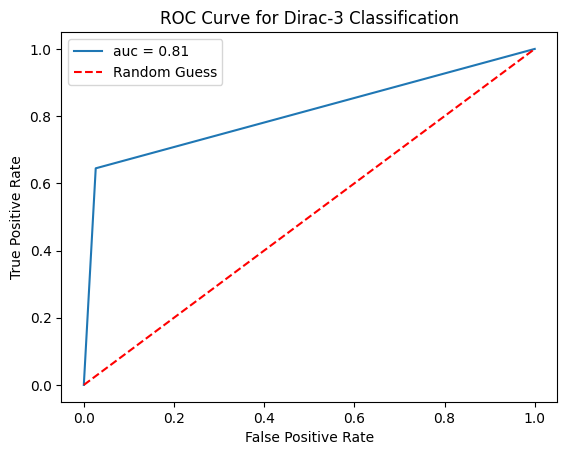

In [ ]:
print(Counter(y_train_prd))
print(Counter(y_test_prd))

print(
    "Train precision:",
    precision_score(y_train, y_train_prd, labels=[-1, 1], pos_label=1),
)
print(
    "Train recall:",
    recall_score(y_train, y_train_prd, labels=[-1, 1], pos_label=1),
)
print(
    "Train accuracy:",
    accuracy_score(y_train, y_train_prd),
)
print(
    "Train confusion matrix:",
)
print(
    confusion_matrix(y_train, y_train_prd, labels=[-1, 1]),
)

print(
    "Test precision:",
    precision_score(y_test, y_test_prd, labels=[-1, 1], pos_label=1),
)
print(
    "Test recall:",
    recall_score(y_test, y_test_prd, labels=[-1, 1], pos_label=1),
)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_test_prd)
area = auc(false_positive_rate, true_positive_rate)
plt.plot(false_positive_rate, true_positive_rate, label=f'auc = {area:.2f}')
plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Dirac-3 Classification')
plt.legend()